In [7]:
import numpy as np

# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile, Aer, IBMQ, execute
from qiskit import QuantumRegister, ClassicalRegister
from qiskit.circuit.library import QFT
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *
from qiskit.providers.aer import QasmSimulator

# Loading your IBM Quantum account(s)
provider = IBMQ.load_account()

<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


# Task 1: Add values
Author: Guillermo Fonseca Kuvacic

This problem consist on finding the combination of numbers that sums up to a specific target number.
For example, the problem of the list of numbers $[1, 2, 3, 6]$ and the target number $6$, has two solutions:
- $[1, 2, 3]$
- $[6]$

A strategy using QRam must be used (a way to encode data in adress of qubits).
The task suggest to use the following structure:

$$|\text{index}\rangle|\text{value}\rangle$$

For the example problem, we need 4 qubits for the index (because there are 4 values), and 4 qubits for the values, because the sum of the list is 12 and to encode this in binary we need at least 4 qubits. Therefore, the encoding of the values is:

$$1 = > |1000\rangle|0001\rangle$$
$$2 = > |0100\rangle|0010\rangle$$
$$3 = > |0010\rangle|0011\rangle$$
$$6 = > |0001\rangle|0110\rangle$$

The task is to find the combinations of the list $[5,7,8,9,1]$ and the target number $16$.

## Strategy
We can divide this problem into subproblems:
- Encode the values in indexes. 
- Sum all the possible combinations.
- Find the combinations that satisfy the target number.
- Return the indexes of the combinations

First thing that we can come up is to directly encode the values specifying the indexes, i.e. only the $|1000\rangle$ index will contain the value $1$. So for the example problem we will have the following quantum state:

$$\frac{1}{2}\left(|1000\rangle|0001\rangle + |0100\rangle|0010\rangle + |0010\rangle|0011\rangle + |0001\rangle|0110\rangle\right)$$

But we can "sum" these values because they are in a quantum superposition.
How can we encode the values in such a way that we can sum then after?

Instead of encode a value in a specific index, we can sum the value to all the possible indexes that have a 1 in the number's position, for example, for the index $|X1XX\rangle$ we should sum $2$ and for the index $|XXX1\rangle$ we should sum $6$. Therefore the index $|0101\rangle$ will have a value of $8$.

We can sum the values using Full Adder, but we would use a lot of qubits and ancillas. Instead we can use Drapper Adder (Draper, 2000).
It works using the Quantum Fourier Transform (QFT).
The QFT is the following operation
$$ \operatorname{QFT}|a\rangle= \frac{1}{\sqrt{2^n}}\sum_{j=0}^{2^n-1} e^{i2\pi(aj)/2^n} |j\rangle $$

It can be shown that, if we define $|\phi_k(a)\rangle$ like $$ |\phi_k(a)\rangle = \frac{1}{\sqrt{2}}\left(|0\rangle + e^{i2\pi a /2^k}|1\rangle \right) $$ 
then we can express QFT as:  $$ \operatorname{QFT}|a\rangle=|\phi_1(a)\rangle\otimes \cdots \otimes |\phi_n(a)\rangle $$

Then, the adder works using the phase between $|0\rangle$ and $|1\rangle$ in the definition of $|\phi_k(a)\rangle$.
The phase angle is proportional to $a$ and if we increase that angle by an amount $b$, we will have the sum $a+b$ when we convert back using the inverse QFT.

$$|\phi_k(a+b)\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle + e^{i2\pi (a+b)/2^k}|1\rangle \right)$$

The rotation must be made considering that numbers are in binary format.
Using little endian encoding starting with 0 (Qiskit default)
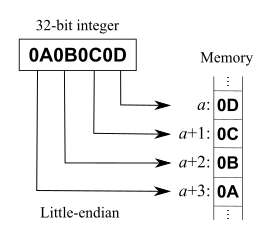
we should re-define $|\phi_k(a+b)\rangle$ .

QFT can be shown to be 
$$ \operatorname{QFT}|a\rangle=|\phi_{n-1}(a)\rangle\otimes \cdots \otimes |\phi_0(a)\rangle $$
therefore $|\phi_k(a+b)\rangle$ is:

$$|\phi_k(a+b)\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle + e^{i2\pi (a+b)/2^{k+1}}|1\rangle \right)$$

$b$ in binary is $$b = 2^{n}b_{n} \ldots + 2^{k}b_{k} \ldots + 2^{0}b_{0}$$
and we can express $b/2^{k+1}$ like $$b/2^{k+1} = \text{some integer} + b_k/2^{1} + b_{k-1}/2^{2} \ldots + b_{0}/2^{k+1}$$
and because of the exponentials, integers can be ignored $$e^{i2\pi(a+\text{integer})} = e^{i2\pi(a)}$$
All this means
$$|\phi_k(a+b)\rangle=\frac{1}{\sqrt{2}}\left(|0\rangle + e^{i2\pi [a/2^k + b_k/2^{1} + b_{k-1}/2^{2} \ldots + b_{0}/2^{k+1}]}|1\rangle \right)$$


Then, for every $|\phi_k(a+b)\rangle$, we should do rotations of angles $\pi b_k$, $\pi b_{k-1}/2^{1}$..., $\pi b_{0}/2^{k}$ around the Z axis

After doing the sum of the numbers of the list, we need to find the combinations that satisfy the target number.

To do this, we can use the Grover's Algorithm. It works by marking the solutions with a negative phase, and then amplifying their probabilities.

Step 1: Prepare all the states. Hadamards gate can be used for this
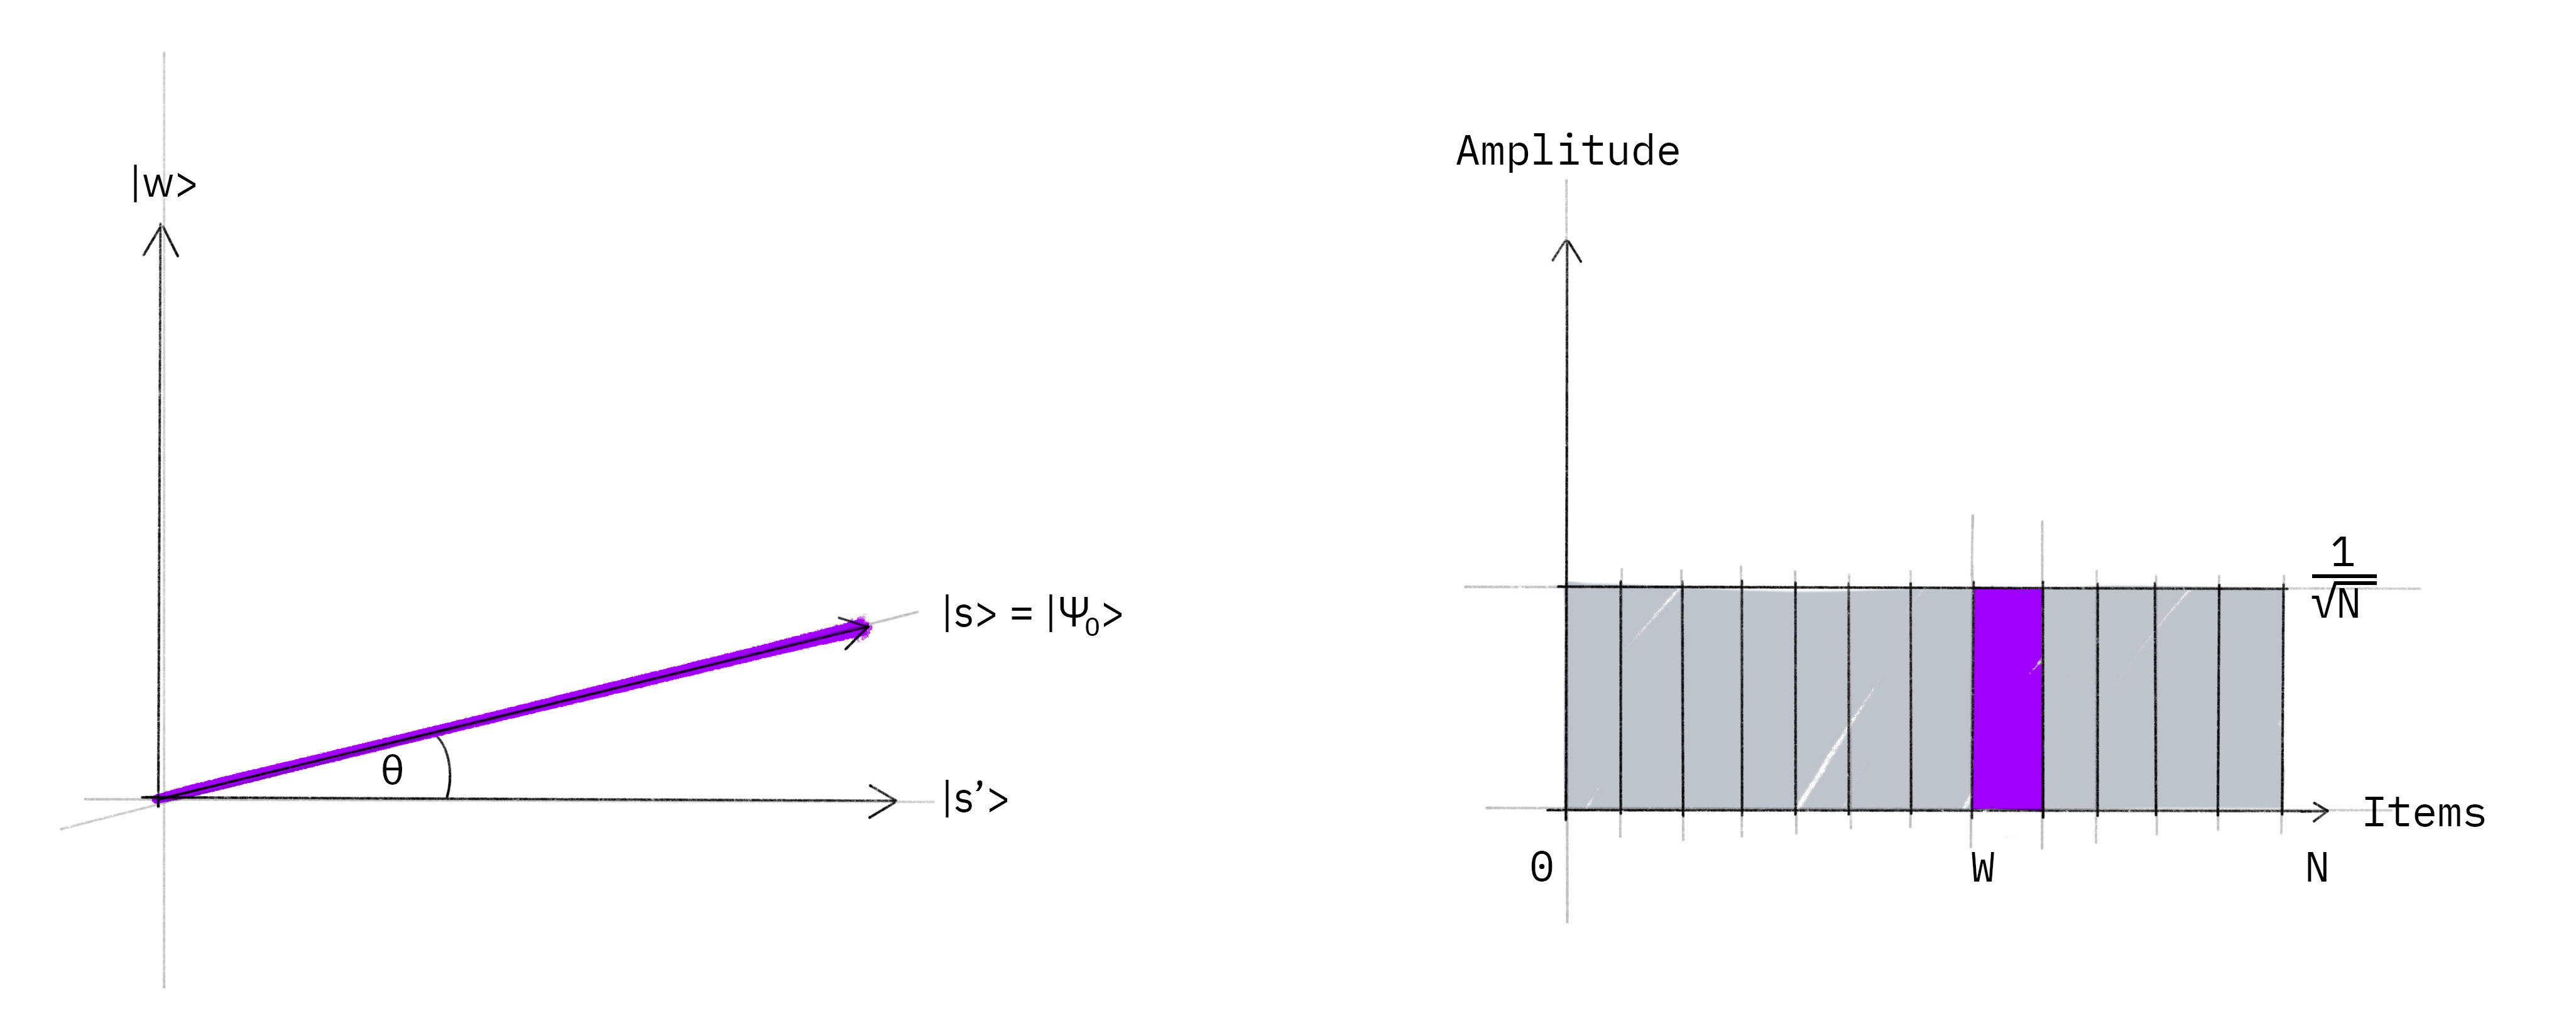
(Qiskit, 2020)

Step 2: put a negative phase in the desired state. For this we use a Oracle gate
    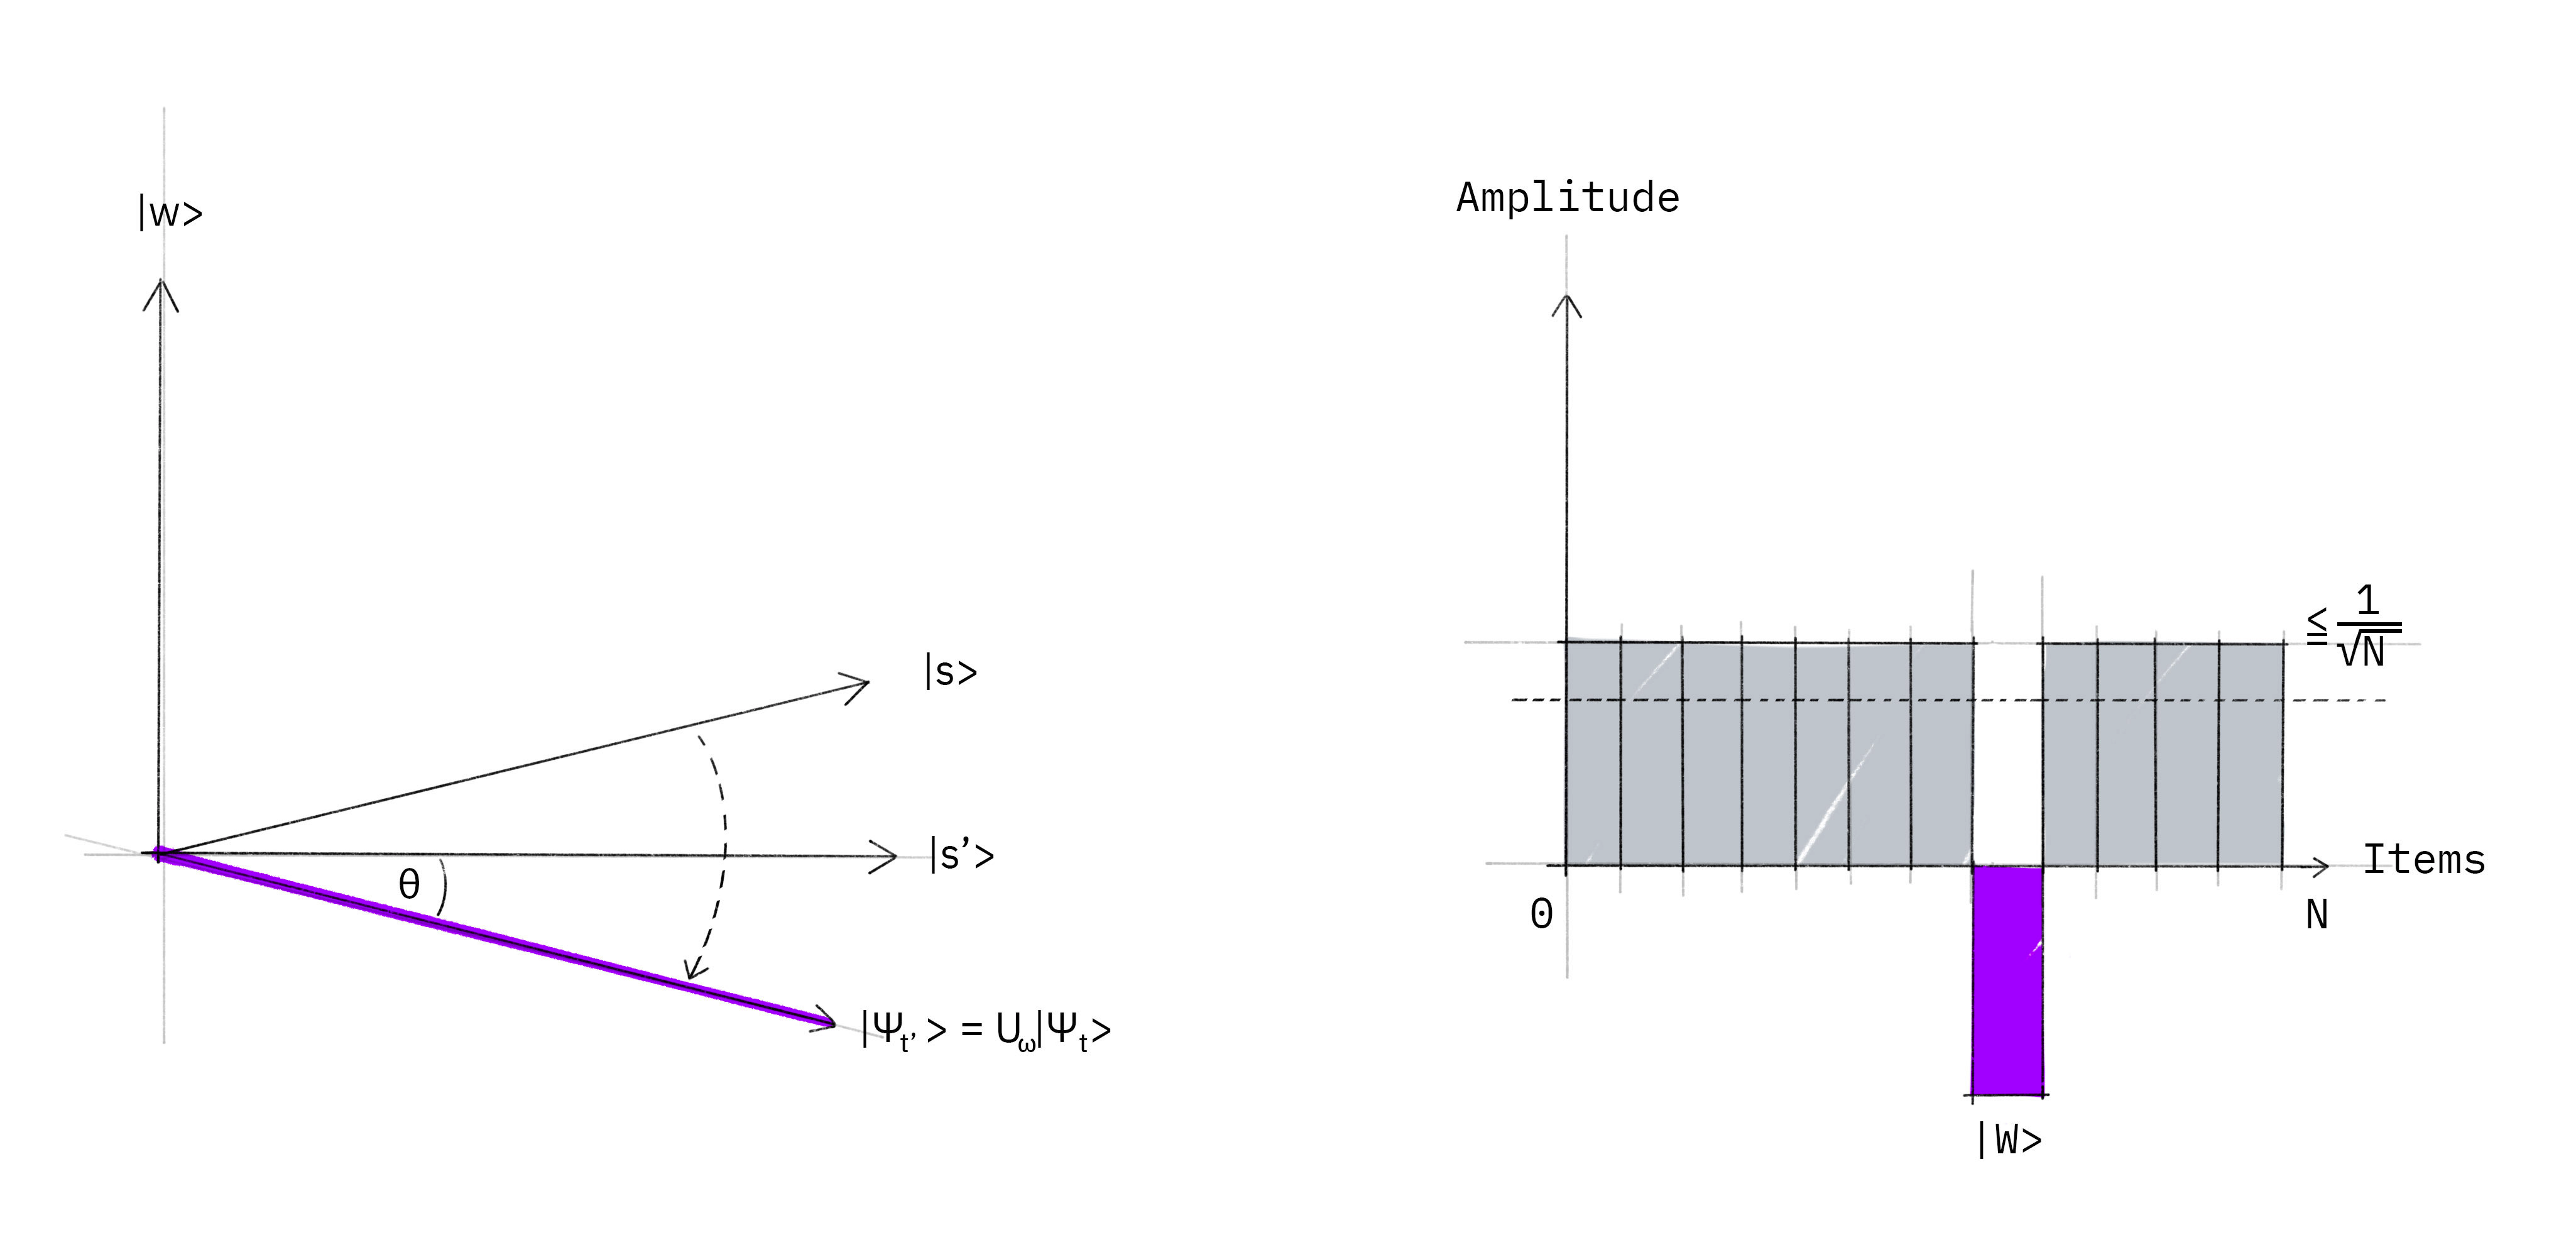
    (Qiskit, 2020)

Step 3:
Amplify the probability of the desired state. For this we use the so-called Diffuser gate.
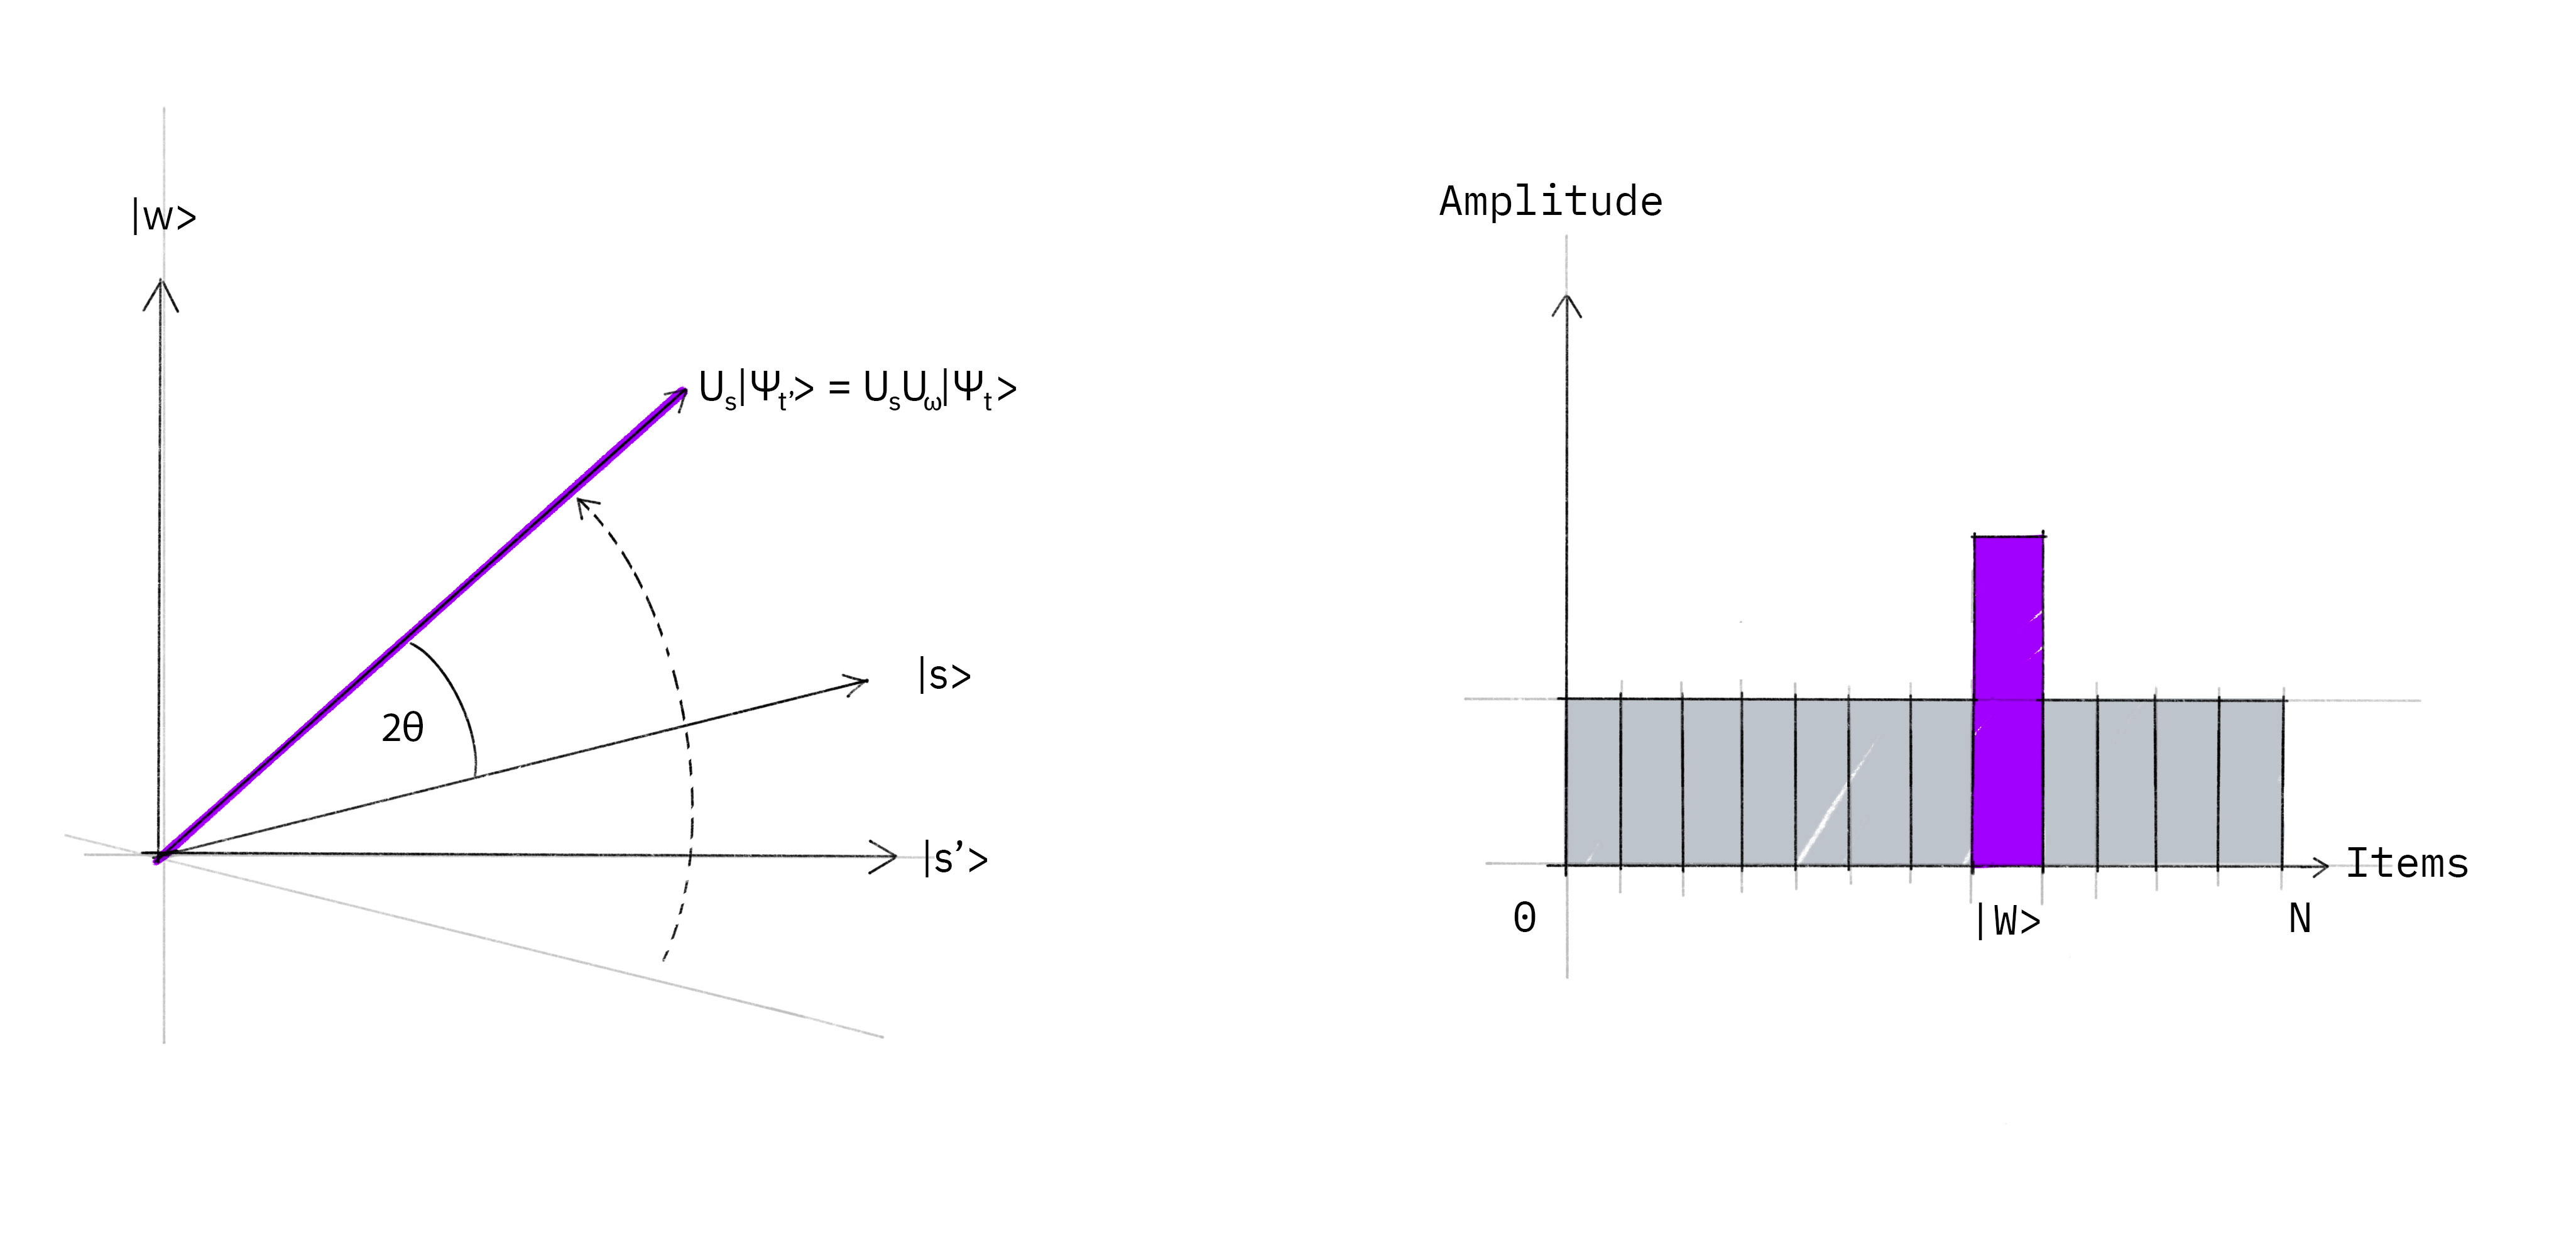
(Qiskit, 2020)

The last two steps represent the Grover's Algorithm.
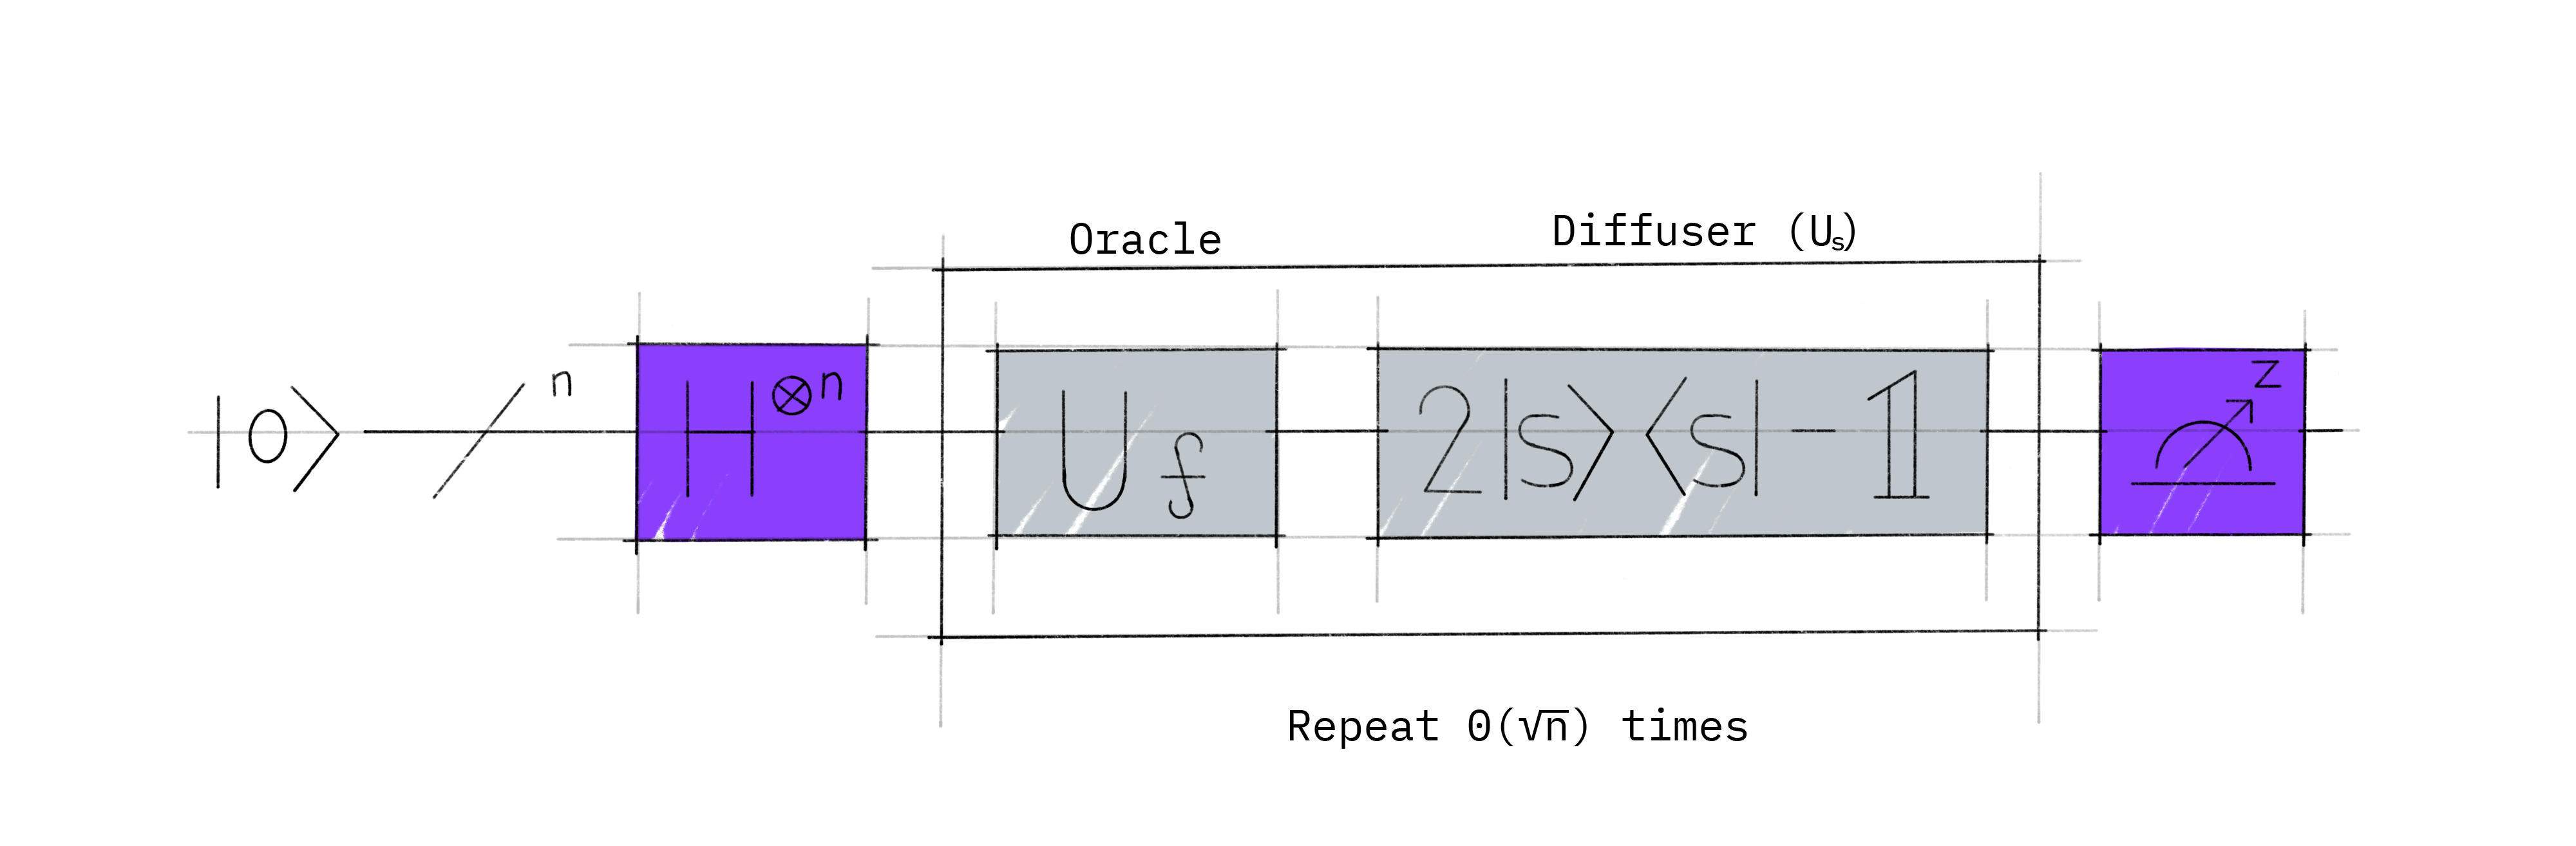
(Qiskit, 2020)

The Grover's Algorithm can be repeated to further amplify the probabilities of the desired solution.

In the case of using qRAM to prepare the states, we need to "uncompute" the preparation after the Oracle, with an inverse operation

Finally, to return the indexes of the combinations, we need to make measurements on the index qubits. For this we need to operate the Oracle on the "data" qubits (the ones where we perform the sum) and operate the Diffuser on the "index" qubits because they have less possible states (because less qubits) and probabilities will amplify better.

## Testing of the Drapper adder

If we want to add $|3\rangle = |011\rangle $ to $|0\rangle = |000\rangle $,

for the first bit (k=0) we should do a rotation of angle $\pi$

for the second bit (k=1) we should do a rotation of angles $\pi$, $\pi/2$

for the third bit (k=2) we should do a rotation of angles $\pi/2$, $\pi/4$

For all rotations, phase gates will be used

In [8]:
def classic_Draper_adder(number, n_qubits_data):
    ''' '''
    data    = QuantumRegister(n_qubits_data, 'data')
    qc_name = f"add {number}"
    qc = QuantumCircuit(data, name=qc_name)
        
    bits = format(number, f'#0{n_qubits_data+2}b')[2:]
    bits = list(bits)
    bits = list(reversed(bits))
    
    for i in range(n_qubits_data):
        for j in range(n_qubits_data - i):
            if bits[i] == '1':
                angle = np.pi / (2**j)
                qc.p(angle, data[j+i])
    return qc

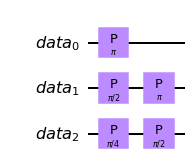

In [19]:
classic_Draper_adder(3, 3).draw()

If we test the Draper adder, adding 1 and 2, using the QFT, we would get the following circuit

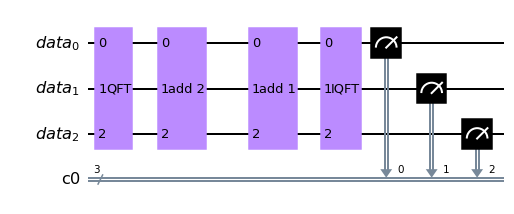

In [16]:
n_qubits_data = 3
data = QuantumRegister(n_qubits_data,   'data')
cr   = ClassicalRegister(n_qubits_data)

qc = QuantumCircuit(data, cr)

qc = qc.compose(QFT(3, do_swaps=False), data[:3])
qc.append(classic_Draper_adder(2, 3), data[:])
qc.append(classic_Draper_adder(1, 3), data[:])
qc = qc.compose(QFT(3, inverse=True, do_swaps=False), data[:3])
# QFT turn do_swaps to false, otherwise it won't make sense

qc.measure(data[:], cr[:])
qc.draw()

In [17]:
def test_circuit(qc, shots=1000, decimal=True):
    backend = Aer.get_backend('qasm_simulator')
    job = execute(qc, backend=backend, shots=shots, seed_simulator=12346)
    result = job.result()
    count = result.get_counts()
    if decimal:
        count = {str(int(key, 2)):value for key,value in count.items()}
    return count

And testing it

CPU times: user 476 ms, sys: 39.1 ms, total: 515 ms
Wall time: 811 ms


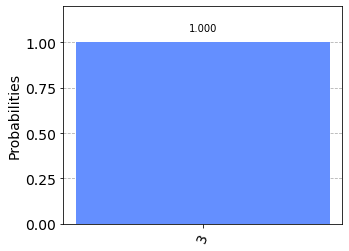

In [18]:
%%time
plot_histogram(test_circuit(qc), figsize=(5,4))

We got 3, as expected

## Adding the qRAM

Now let's add the index (adress) part. For this we need to use controlled phase gates, controlled by adress qubits

In [7]:
def qRAM_Draper_adder(number, n_qubits_data):
    ''' '''
    adress  = QuantumRegister(1, 'adress')
    data    = QuantumRegister(n_qubits_data,   'data')
    qc_name = f"qRAM add {number}"
    qc = QuantumCircuit(adress, data, name=qc_name)
        
    bits = format(number, f'#0{n_qubits_data+2}b')[2:]
    bits = list(bits)
    bits = list(reversed(bits))
    
    for i in range(n_qubits_data):
        for j in range(n_qubits_data - i):
            if bits[i] == '1':
                angle = np.pi / (2**j)
                qc.cp(angle, adress, data[j+i])
    return qc

In the following circuit, if the adress qubit is $|1\rangle$, we will be adding $|3\rangle$ to the data qubits

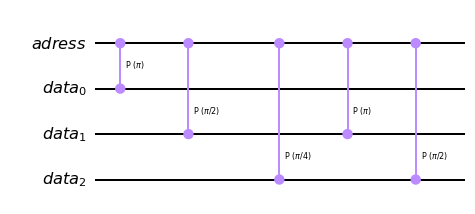

In [8]:
qRAM_Draper_adder(3, 3).draw()

We can use the above "qRAM_Draper_adder" function to add $|2\rangle$ and $|3\rangle$ in the following circuit

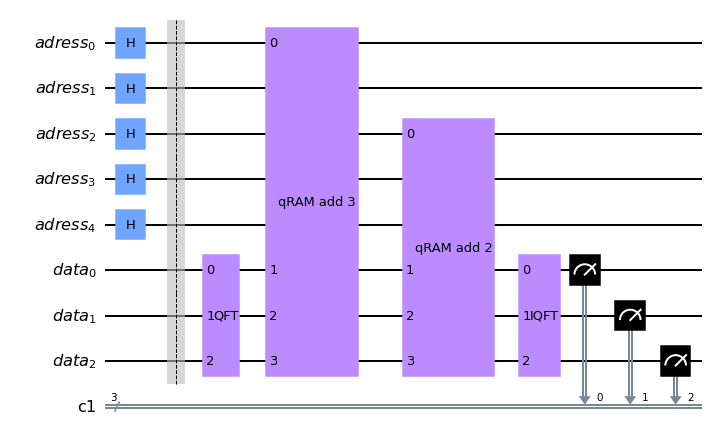

In [9]:
n_qubits_data = 3
n_qubits_adress = 5
adress  = QuantumRegister(n_qubits_adress, 'adress')
data    = QuantumRegister(n_qubits_data,   'data')
cr      = ClassicalRegister(n_qubits_data)

qc = QuantumCircuit(adress, data, cr)

qc.h(adress[:])

qc.barrier()
qc = qc.compose(QFT(n_qubits_data, do_swaps=False), data)
qc.append(qRAM_Draper_adder(3, 3), [adress[0]] + data[:])
qc.append(qRAM_Draper_adder(2, 3), [adress[2]] + data[:])
qc = qc.compose(QFT(n_qubits_data, inverse=True, do_swaps=False), data)

qc.measure(data[:], cr[:])
qc.draw()

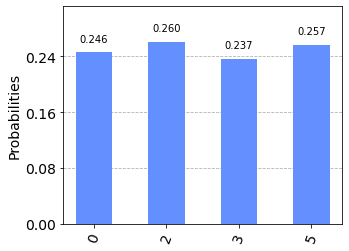

In [10]:
plot_histogram(test_circuit(qc), figsize=(5,4))

We got all the possible combinations of the numbers $[2,3]$, plus the no elements, as expected.

In [11]:
del n_qubits_adress, n_qubits_data

Now with a list of numbers, we have the following function

In [12]:
def full_qRAM_adder(list_numbers):
    n_qubits_adress = len(list_numbers)
    sum_list = sum(list_numbers)
    n_qubits_data = int(np.ceil(  np.log(sum_list)/np.log(2)  ))
    
    adress = QuantumRegister(n_qubits_adress, 'adress')
    data   = QuantumRegister(n_qubits_data,   'data')
    qc = QuantumCircuit(adress, data, name='qRAM')

    qc = qc.compose(QFT(n_qubits_data, do_swaps=False), data)
    for i, number in enumerate(list_numbers):
        qc.append(qRAM_Draper_adder(number, n_qubits_data), [adress[n_qubits_adress-i-1]] + data[:])
    qc = qc.compose(QFT(n_qubits_data, inverse=True, do_swaps=False), data)
    return qc

Note that, if we sum all the numbers on a list and it gives $x$, the numbers of qubits needed to represent it in binary are $$\text{ceil}\left(\frac{log(x)}{log(2)}\right)$$
And he numbers of qubits needed for the indexes (adress), is the number of elements in the list.

Using the list of numbers $[1,2,3]$, we have the following circuit

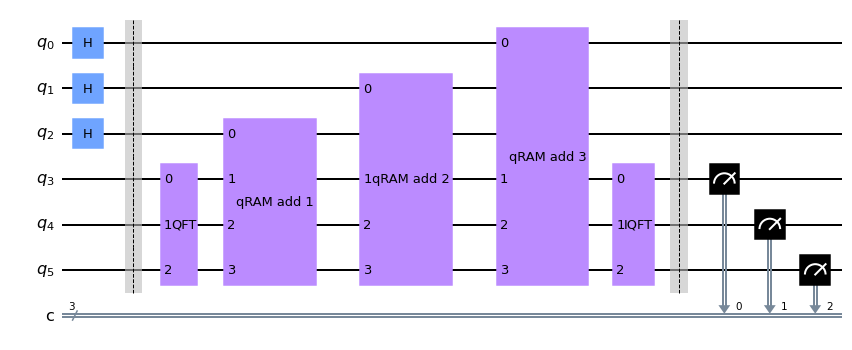

In [14]:
list_numbers = [1,2,3]
qc = QuantumCircuit(6, 3)
qc.h(range(3))
qc.barrier()
qc = qc.compose(full_qRAM_adder(list_numbers), range(6))
qc.barrier()
qc.measure(range(3,6), range(3))
qc.draw()

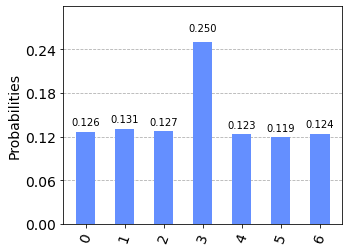

In [15]:
plot_histogram(test_circuit(qc, shots=8000), figsize=(5,4))

Here we have all the possible combinations of adding the numbers of the list $[1,2,3]$ plus the no elements.
Note that we have a higher probability in $3$, as expected because of the two combinations, $[1,2]$ and $[3]$.

## Oracle and Grover algorithm

For the Oracle part, we use a multicontrolled gate, with the "data" as the controlling qubits (the ones with the sum), and with a "flag" as the target qubit, the one we will be changing it's state.

To create the circuit, we need to take the binary representation of the target number, and according to that, we use X-gates to try to convert the target number state all to 1. Once we do that, we can use a multi controlled X gate, to change the phase of the flag qubit, but before that, we need to prepare it because initially it is in the 0 state. 

Using a X and Hadamard gate, we convert the 0 into a $1/\sqrt{2}(|0\rangle-|1\rangle)=|-\rangle$, here we have changed the basis of the qubit.

If all control qubits activate the gate, then the flag state will change the 0 into a 1 and the 1 into a 0, leaving $1/\sqrt{2}(|1\rangle-|0\rangle)=-|-\rangle$. 

Now if we change it back to the original basis, we will have either $|0\rangle$ or $-|0\rangle$ depending on the controll qubits.

Finally we need to uncompute the X-gates of the data qubits.

In [16]:
def oracle_circ(target, n_qubits_data):
    flag = QuantumRegister(1, 'flag')
    data = QuantumRegister(n_qubits_data, 'data')
    qc = QuantumCircuit(flag, data, name='oracle')
    
    bits = format(target, f'#0{n_qubits_data+2}b')[2:]
    bits = list(bits)
    bits = list(reversed(bits))
    
    for i in range(n_qubits_data):
        if bits[i] == '0':
            qc.x(data[i])
    
    qc.x(flag)
    qc.h(flag)
    qc.mcx(data, flag)
    qc.h(flag)
    qc.x(flag)
    
    for i in range(n_qubits_data):
        if bits[i] == '0':
            qc.x(data[i])
    return qc

For example, the oracle for the number 5 will look like the following circuit

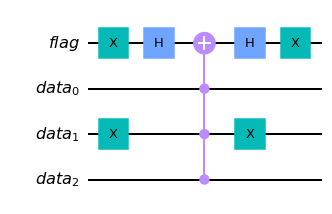

In [17]:
oracle_circ(5, 3).draw()

Now for the Diffuser circuit, we just need to do $$H^{\otimes n}U_0 H^{\otimes n}$$, where $U_0$ is gate that flip the phase of the states to negative, except the zero state.

We can implement $U_0$ with the same strategy as the Oracle.

In [21]:
def diffuser_circ(n_qubits):
    qbits = QuantumRegister(n_qubits)
    qc = QuantumCircuit(qbits, name='diffuser')
    
    # Preparation
    qc.h(qbits)
    qc.barrier()
    # S0
    qc.x(qbits)
    qc.h(qbits[-1])
    qc.mcx(qbits[:-1], qbits[-1])
    qc.h(qbits[-1])
    qc.x(qbits)
    # inverse Preparation
    qc.barrier()
    qc.h(qbits)
    
    return qc

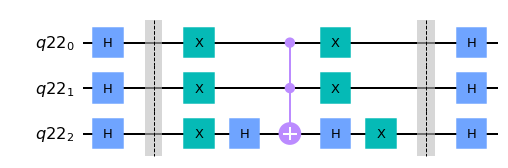

In [23]:
diffuser_circ(3).draw()

### Constructing the Grover's Algorithm

Now putting the Oracle and Diffuser together, forms a circuit that implements the Grover's Algorithm with one iteration.
As an example, we will be prepare data qubits in all states, and an oracle will select the one with the number 6.

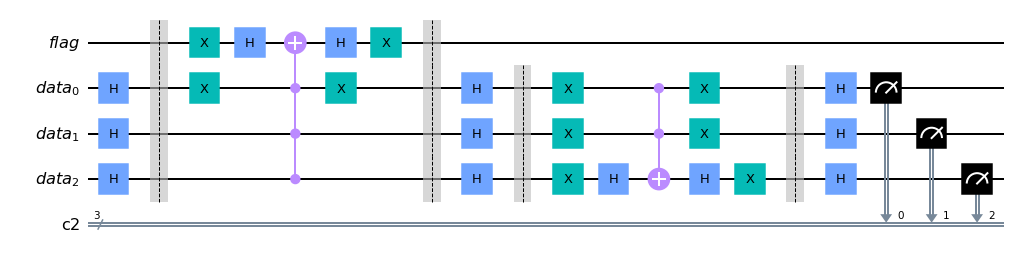

In [19]:
from qiskit.circuit.library import GroverOperator
flag  = QuantumRegister(1, 'flag')
data  = QuantumRegister(3, 'data')
cr    = ClassicalRegister(3)
qc = QuantumCircuit(flag, data, cr)

qc.h(data)
    
qc.barrier()

oracle = oracle_circ(target = 6, n_qubits_data=3)

diffuser = diffuser_circ(n_qubits = 3)

qc = qc.compose(oracle, flag[:] + data[:])
qc.barrier()
qc = qc.compose(diffuser, data[:])

qc.measure(data, cr)
qc.draw()

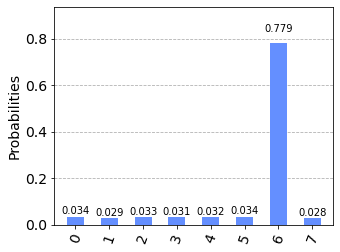

In [20]:
plot_histogram(test_circuit(qc, shots=8000), figsize=(5,4))

And as expected, the most likely state is the one with 6.

## Full circuit

Now putting everything together, we can solve the problem.
Note that to make use of the Diffuser in the indexes (adress) qubits, we need to uncompute the qRAM operation first. We want to do this because otherwise probabilities won't amplify too much and could only use one iteration.

In [21]:
def circuit_solution(list_numbers, target, n_iter=1):
    n_qubits_adress = len(list_numbers)
    sum_list = sum(list_numbers)
    n_qubits_data = int(np.ceil(  np.log(sum_list)/np.log(2)  ))
    
    flag    = QuantumRegister(1, 'flag')
    data    = QuantumRegister(n_qubits_data,   'data')
    adress  = QuantumRegister(n_qubits_adress, 'adress')
    cr      = ClassicalRegister(n_qubits_data)
    
    qc = QuantumCircuit(flag, data, adress, cr)
    
    qc.h(adress)
    qc.barrier()
    
    for i in range(n_iter):
        # qRAM adder
        qram = full_qRAM_adder(list_numbers)
        qc.append(qram, adress[:] + data[:])
        qc.barrier()
        
        ## Grover's Algorithm
        # Oracle
        oracle = oracle_circ(target = target, n_qubits_data=n_qubits_data)
        qc.append(oracle, flag[:] + data[:])
        qc.barrier()

        qc.append(qram.inverse(), adress[:] + data[:])
        qc.barrier()

        # Diffuser
        diffuser_qubits = adress[:]#data[:] + adress[:]
        diffuser = diffuser_circ(n_qubits = len(diffuser_qubits))
        qc.append(diffuser, diffuser_qubits)
        qc.barrier()

    # Measure
    qc.measure(adress, cr)
    return qc    

For the list of numbers $[1, 2, 3]$, the target number $6$ and two iterations, we have the following circuit.

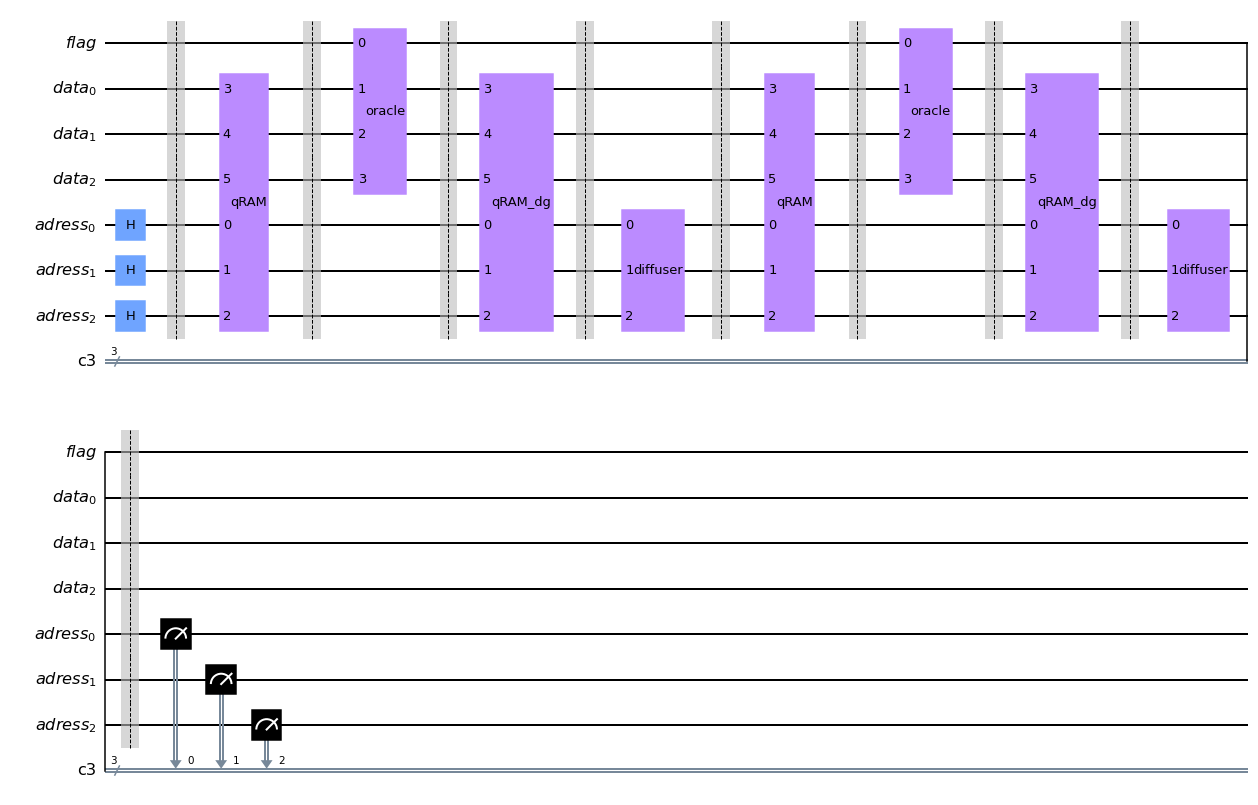

In [22]:
qc = circuit_solution([1, 2, 3], 6, n_iter=2)
qc.draw()

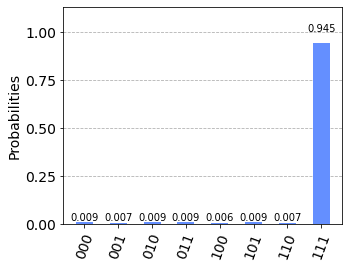

In [23]:
plot_histogram(test_circuit(qc, shots=8000, decimal=False), figsize=(5,4))

Here we got the most likely state as $|111\rangle$, this means only the full combination of numbers $[1,2,3]$ add up to $6$, as expected.
Now if we add a $6$ to that list of numbers, we have the following results:

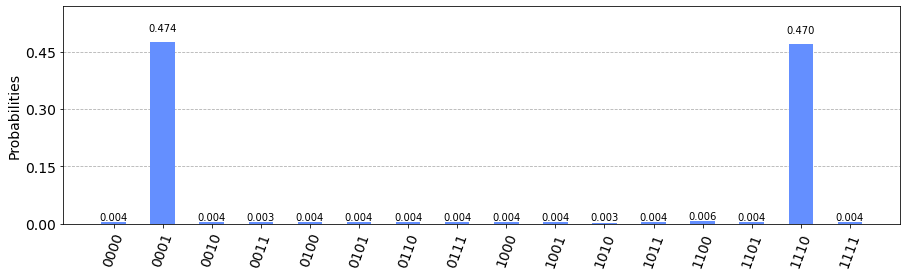

In [24]:
qc = circuit_solution([1, 2, 3, 6], 6, n_iter=2)
plot_histogram(test_circuit(qc, shots=10000, decimal=False), figsize=(15,4))

Now we have two most likely solutions, $0001=> [6]$ and $1110=> [1,2,3]$, as expected

# Solution to the exercise
Finally, for the list of numbers $[5,7,8,9,1]$ and the target number $16$, we have the following results:

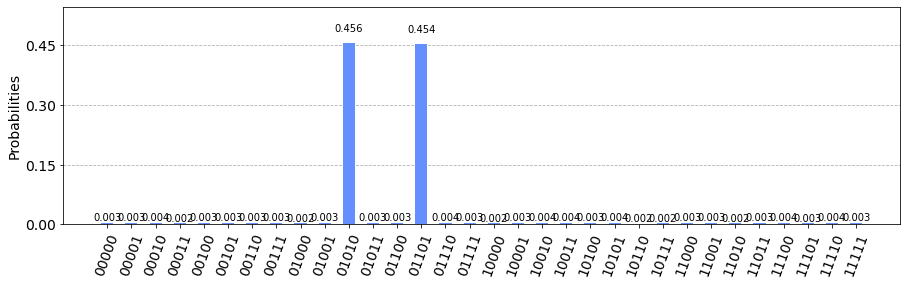

In [25]:
qc = circuit_solution([5,7,8,9,1], 16, n_iter=2)
plot_histogram(test_circuit(qc, shots=10000, decimal=False), figsize=(15,4))

Where we got $01010=> [7,9]$ and $01101=> [7,8,1]$, where we can verify that both sums are 16.

# References
Amira Abbas, Stina Andersson, Abraham Asfaw, Antonio Corcoles, Luciano Bello, Yael Ben-Haim, Mehdi Bozzo-Rey, Sergey Bravyi, Nicholas Bronn, Lauren Capelluto, Almudena Carrera Vazquez, Jack Ceroni, Richard Chen, Albert Frisch, Jay Gambetta, Shelly Garion, Leron Gil, Salvador De La Puente Gonzalez, Francis Harkins, Takashi Imamichi, Pavan Jayasinha, Hwajung Kang, Amir h. Karamlou, Robert Loredo, David McKay, Alberto Maldonado, Antonio Macaluso, Antonio Mezzacapo, Zlatko Minev, Ramis Movassagh, Giacomo Nannicini, Paul Nation, Anna Phan, Marco Pistoia, Arthur Rattew, Joachim Schaefer, Javad Shabani, John Smolin, John Stenger, Kristan Temme, Madeleine Tod, Ellinor Wanzambi, Stephen Wood, & James Wootton (2020). Learn Quantum Computation Using Qiskit.

(Images retrieved from https://qiskit.org/textbook/ch-algorithms/grover.html)


Draper, T. G. (2000). Addition on a quantum computer. arXiv preprint quant-ph/0008033.